In [1]:
import numpy as np
import pandas as pd
import torch
from scipy.linalg import toeplitz
from scipy.stats import norm

import matplotlib.pyplot as plt
from tableone import TableOne
from sksurv.nonparametric import kaplan_meier_estimator

from utils import data_processing, visualization
from utils.simulations import *
from execute import surv_hivae, surv_gan, surv_vae
#from utils.metrics import log_rank, cox_estimation

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


## Simulate the initial data

In [2]:
n_samples = 600
n_features_bytype = 4
n_features_multiplier = 3 

treatment_effect = 0.

control, treated, types = simulation(treatment_effect, n_samples, feature_types_list = ["real", "cat"], surv_type = "surv_piecewise")
control = control.drop(columns='treatment')
treated = treated.drop(columns='treatment')

In [3]:
control.head()

,0,1,2,3,4,5,6,7,time,censor
0,0.062584,-1.336203,-0.399935,-0.352406,0.0,0.0,0.0,1.0,0.944799,1
4,-0.904562,-0.568661,-0.853502,0.557978,1.0,1.0,1.0,1.0,1.515461,1
8,-1.457118,-0.937230,0.507312,0.296675,1.0,1.0,0.0,0.0,1.391274,1
9,-0.767104,-1.099234,-1.408296,-1.395563,0.0,1.0,1.0,0.0,0.364506,1
10,1.959621,1.324827,0.295694,0.136266,1.0,1.0,0.0,1.0,2.841112,1


In [4]:
print("Percent of uncensored data in control set {:.3f} and in treated set {:.3f}".format(np.mean(control['censor']), 
                                                                                          np.mean(treated['censor'])))

Percent of uncensored data in control set 0.922 and in treated set 0.901


## Save data

In [5]:
dataset_name = "Simulations"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
miss_file = "dataset/" + dataset_name + "/Missing.csv"
true_miss_file = None

control.to_csv(data_file_control,index=False , header=False)
types.to_csv(feat_types_file_control)
treated.to_csv(data_file_treated,index=False , header=False)
types.to_csv(feat_types_file_treated)

## Generation

In [6]:
# Load and transform control data
data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                             feat_types_file_control, 
                                                                                                             miss_file, true_miss_file,
                                                                                                             surv_type = "surv_piecewise")
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                         miss_file, true_miss_file, surv_type = "surv_piecewise")
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [7]:
fnames = types['name'][:-1].tolist()
fnames.append("time")#.append("censor")
fnames.append("censor")

In [8]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)

# Update the data
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

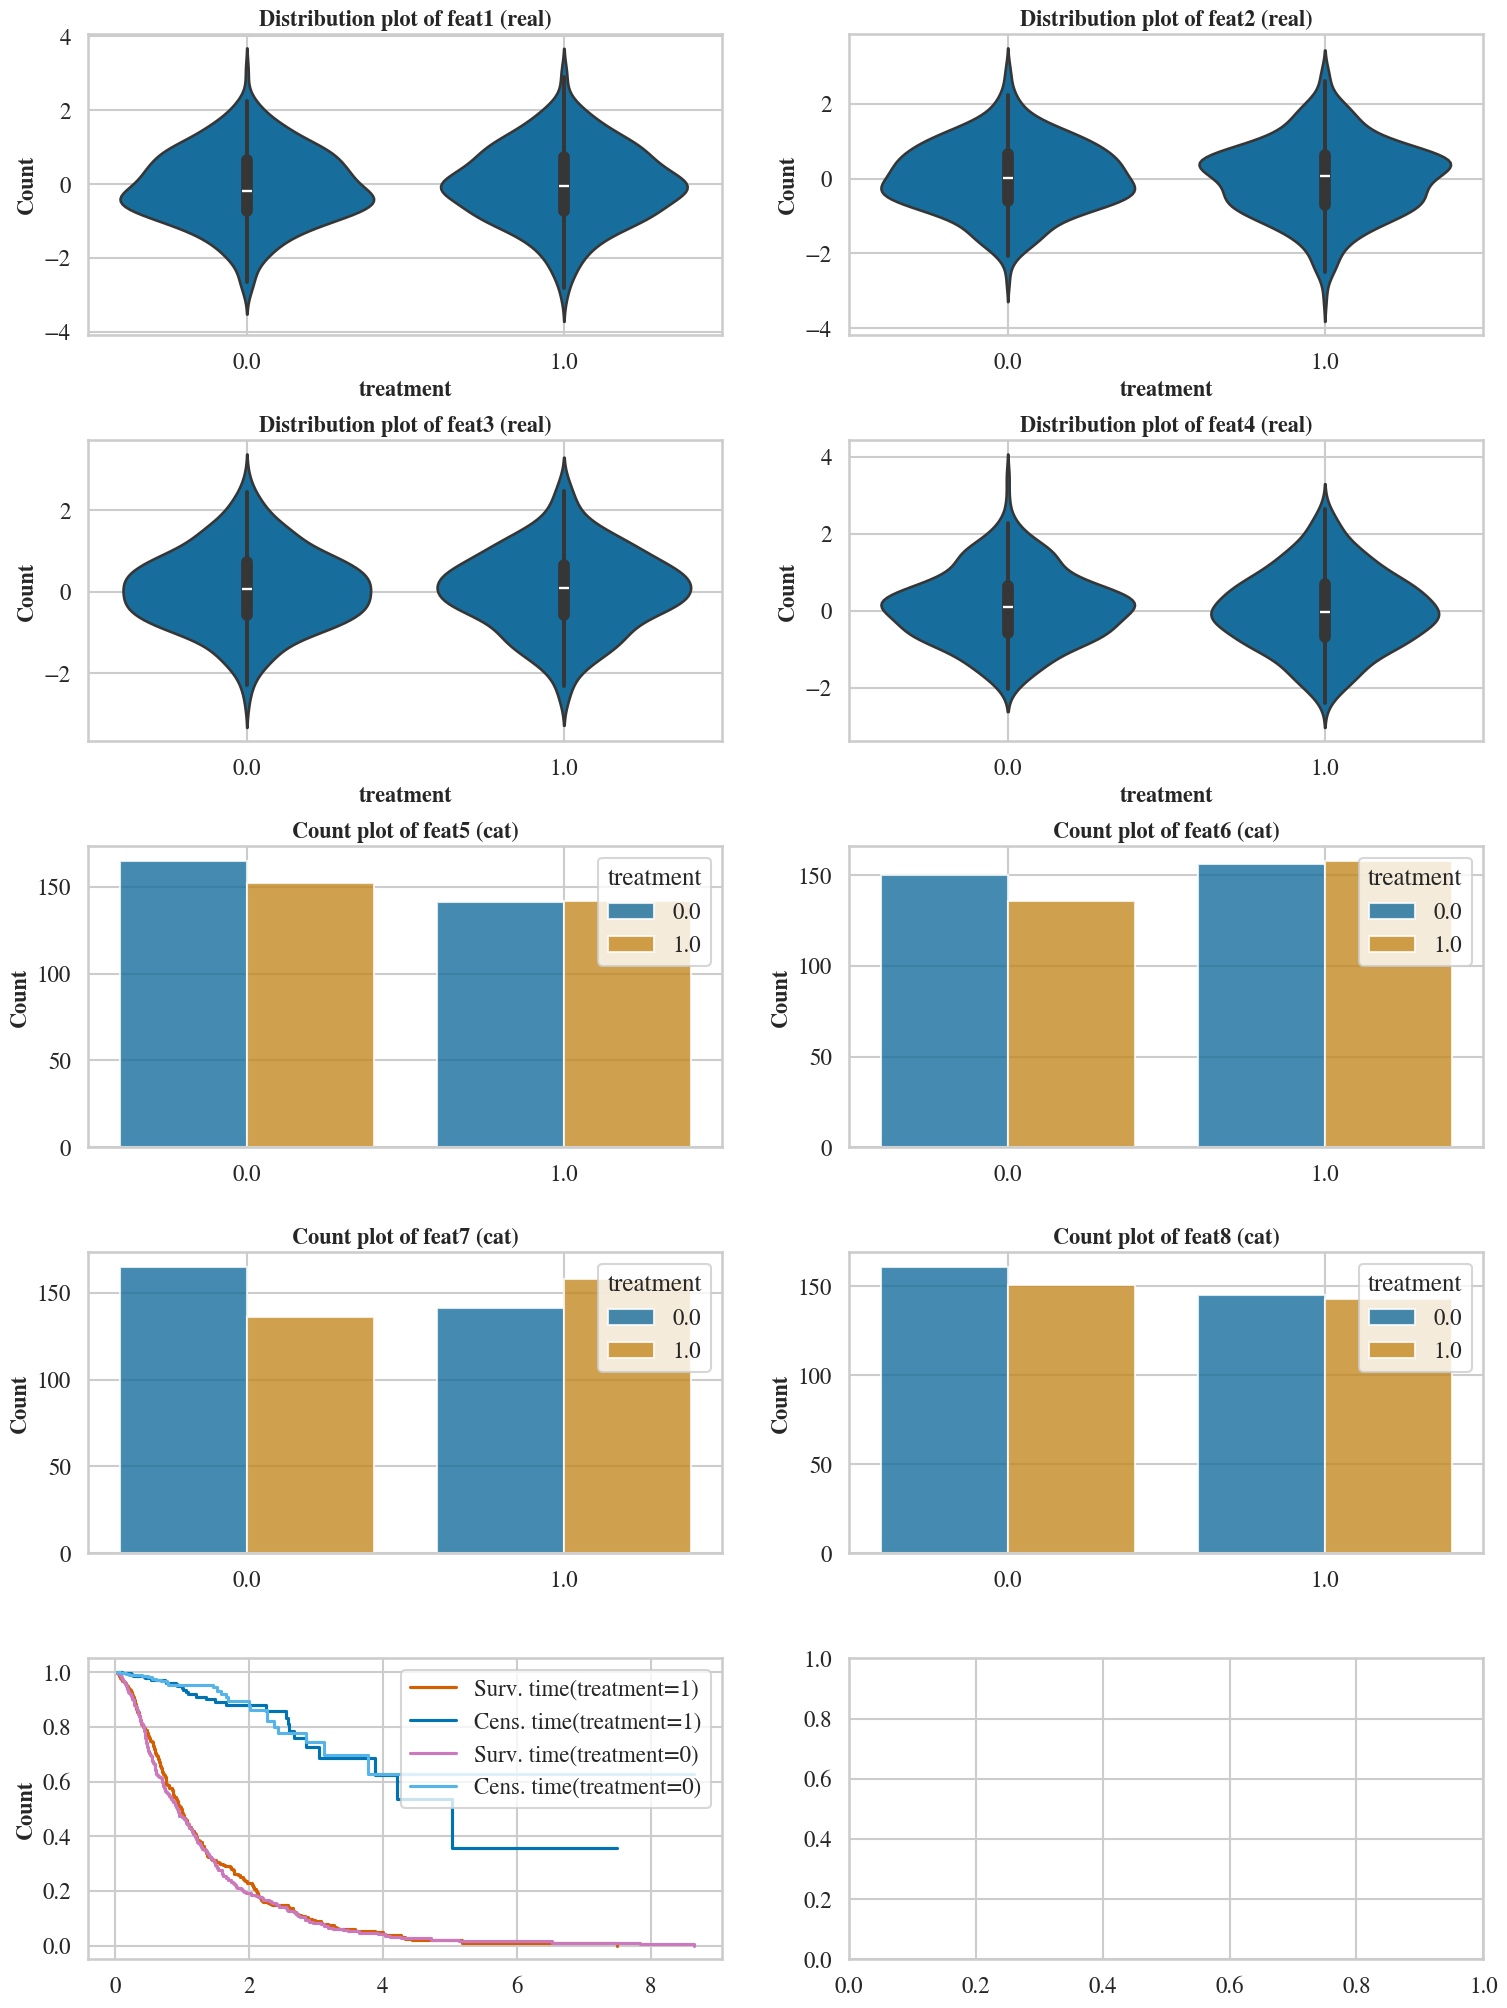

In [9]:
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_data(df_init.to_numpy(), feat_types_dict_all, feat_comparison_name='treatment')

In [10]:
# the datasets used for training is data_init_control
T_surv = torch.Tensor(df_init_control.time)
T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
n_intervals = 10
T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]

In [11]:
n_generated_dataset = 1
data_gen_control_hivae = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, 
                                  true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_dataset)

data_gen_control_survgan = surv_gan.run(data_init_control, columns=fnames, target_column="censor", 
                                time_to_event_column="time", n_generated_sample=n_generated_dataset)


data_gen_control_survvae = surv_vae.run(data_init_control, columns=fnames, target_column="censor", 
                                time_to_event_column="time", n_generated_sample=n_generated_dataset)

Epoch: [ 0]  time: 0.0149, ELBO_train: -10.62334824, KL_z: 1.82937026, KL_s: 0.08978450, reconstruction loss: -8.70419347
Epoch: [100]  time: 1.0188, ELBO_train: -8.33305645, KL_z: 0.63550305, KL_s: 0.02879286, reconstruction loss: -7.66876054
Epoch: [200]  time: 2.1014, ELBO_train: -7.25787807, KL_z: 0.68627977, KL_s: 0.02252698, reconstruction loss: -6.54907131
Epoch: [300]  time: 3.0781, ELBO_train: -7.62570000, KL_z: 0.80783251, KL_s: 0.02464437, reconstruction loss: -6.79322311
Epoch: [400]  time: 4.0902, ELBO_train: -7.27418065, KL_z: 0.86721727, KL_s: 0.02538180, reconstruction loss: -6.38158157
Training finished.


[2025-05-27T13:36:46.725975+0200][70952][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-27T13:36:47.922439+0200][70952][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


 20%|█▉        | 1999/10000 [01:05<04:24, 30.31it/s]
[2025-05-27T13:37:54.579290+0200][70952][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-27T13:37:54.593509+0200][70952][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 40%|████      | 400/1000 [00:19<00:29, 20.08it/s]


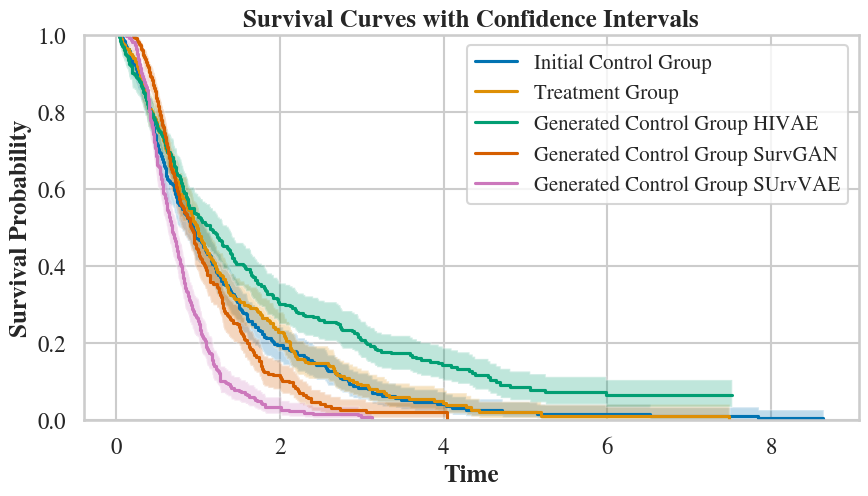

In [12]:
surv_time_control_init  = control['time'].values
surv_ind_control_init = control['censor'].values.astype(bool)

surv_time_treated_init = treated['time'].values
surv_ind_treated_init = treated['censor'].values.astype(bool)

i=0
df_syn_sel = pd.DataFrame(data_gen_control_hivae[i].numpy(), columns=fnames)
surv_time_control_gen = df_syn_sel['time'].values
surv_ind_control_gen = df_syn_sel['censor'].values.astype(bool)

df_syn_sel2 = pd.DataFrame(data_gen_control_survgan[i].numpy(), columns=fnames)
surv_time_control_gen2 = df_syn_sel2['time'].values
surv_ind_control_gen2 = df_syn_sel2['censor'].values.astype(bool)

df_syn_sel3 = pd.DataFrame(data_gen_control_survvae[i].numpy(), columns=fnames)
surv_time_control_gen3 = df_syn_sel3['time'].values
surv_ind_control_gen3 = df_syn_sel3['censor'].values.astype(bool)

uniq_time_control_init, surv_prob_control_init, conf_int_control_init = kaplan_meier_estimator(surv_ind_control_init, surv_time_control_init, conf_type="log-log")
uniq_time_treated_init, surv_prob_treated_init, conf_int_treated_init = kaplan_meier_estimator(surv_ind_treated_init, surv_time_treated_init, conf_type="log-log")
uniq_time_control_gen, surv_prob_control_gen, conf_int_control_gen = kaplan_meier_estimator(surv_ind_control_gen, surv_time_control_gen, conf_type="log-log")
uniq_time_control_gen2, surv_prob_control_gen2, conf_int_control_gen2 = kaplan_meier_estimator(surv_ind_control_gen2, surv_time_control_gen2, conf_type="log-log")
uniq_time_control_gen3, surv_prob_control_gen3, conf_int_control_gen3 = kaplan_meier_estimator(surv_ind_control_gen3, surv_time_control_gen3, conf_type="log-log")

plt.figure(figsize=(10, 5))
plt.step(uniq_time_control_init, surv_prob_control_init, where="post", label="Initial Control Group")
plt.fill_between(uniq_time_control_init, conf_int_control_init[0], conf_int_control_init[1], alpha=0.25, step="post")

plt.step(uniq_time_treated_init, surv_prob_treated_init, where="post", label="Treatment Group")
plt.fill_between(uniq_time_treated_init, conf_int_treated_init[0], conf_int_treated_init[1], alpha=0.25, step="post")

plt.step(uniq_time_control_gen, surv_prob_control_gen, where="post", label="Generated Control Group HIVAE")
plt.fill_between(uniq_time_control_gen, conf_int_control_gen[0], conf_int_control_gen[1], alpha=0.25, step="post")


plt.step(uniq_time_control_gen2, surv_prob_control_gen2, where="post", label="Generated Control Group SurvGAN")
plt.fill_between(uniq_time_control_gen2, conf_int_control_gen2[0], conf_int_control_gen2[1], alpha=0.25, step="post")


plt.step(uniq_time_control_gen3, surv_prob_control_gen3, where="post", label="Generated Control Group SUrvVAE")
plt.fill_between(uniq_time_control_gen3, conf_int_control_gen3[0], conf_int_control_gen3[1], alpha=0.25, step="post")


plt.ylim(0, 1)
plt.legend(fontsize=15)
plt.xlabel("Time", fontweight="semibold")
plt.ylabel("Survival Probability", fontweight="semibold")
plt.title("Survival Curves with Confidence Intervals", fontweight="bold")
plt.show()

In [14]:
print("-Log rank pvalues: \n Initial {:.2f} \n HIVAE {:.2f} \n SurvGAN {:.2f} \n SurvVAE {:.2f}".format(compute_logrank_test(control, treated), 
                                                                                                        compute_logrank_test(df_syn_sel, treated),
                                                                                                        compute_logrank_test(df_syn_sel2, treated),
                                                                                                        compute_logrank_test(df_syn_sel3, treated)))

-Log rank pvalues: 
 Initial 0.54 
 HIVAE 7.40 
 SurvGAN 5.22 
 SurvVAE 32.59


## Replication

In [14]:
n_generated_dataset = 50
dataset_name = "Simulations"
n_samples = 600
n_features_bytype = 4
n_active_features = 3
treatment_effects = np.arange(0., .6, .25)

In [15]:
M = 10
log_p_value = []
log_p_value_gen = []
simu_num = []
H0_coef = []
seed = 0
for treatment_effect in treatment_effects:
    for m in np.arange(M):
        seed += 1
        control, treated = simulation(treatment_effect, n_samples, feature_types_list=["real", "cat"], 
                                      n_features_bytype=n_features_bytype, n_active_features=n_active_features, data_types_create=False, seed=seed)
        
        control = control.drop(columns='treatment')
        treated = treated.drop(columns='treatment')
        
        data_file_control= "./dataset/" + dataset_name + "/data_control_gen" + str(m) +".csv"
        data_file_treated= "./dataset/" + dataset_name + "/data_treated_gen" + str(m) +".csv"
        
        
        control.to_csv(data_file_control,index=False , header=False)
        treated.to_csv(data_file_treated,index=False , header=False)
        
        df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
        df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)
        
        T_surv = torch.Tensor(df_init_control.time)
        T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
        n_intervals = 5
        T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
        T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
        intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]
        
        p_value_init = compute_logrank_test(control, treated)
    
        # Load and transform control data
        data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                                     feat_types_file_control, 
                                                                                                                     miss_file, true_miss_file,
                                                                                                                     surv_type = "surv_piecewise")
        data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)
        
        # Load and transform treated data
        data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                                 miss_file, true_miss_file, surv_type = "surv_piecewise")
        data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

        data_gen_control = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, 
                                      true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_dataset, verbose=False)
        
        for i in range(n_generated_dataset):
            df_gen_control = pd.DataFrame(data_gen_control[i].numpy(), columns=fnames)
            df_gen_control['treatment'] = 0
            log_p_value.append(p_value_init)
            simu_num.append(m)
            p_value_gen = compute_logrank_test(df_gen_control, treated)
            log_p_value_gen.append(p_value_gen)
            H0_coef.append(treatment_effect)


In [16]:
results = pd.DataFrame({'XP_num' : simu_num, "log_pvalue_init" : log_p_value, "log_pvalue_gen" : log_p_value_gen , "H0_coef" : H0_coef})
results["reject_H0_init"] = results['log_pvalue_init'] > -np.log(0.05)
results["reject_H0_gen"] = results['log_pvalue_gen'] > -np.log(0.05)
results.to_csv("./dataset/" + dataset_name + "results_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".csv")

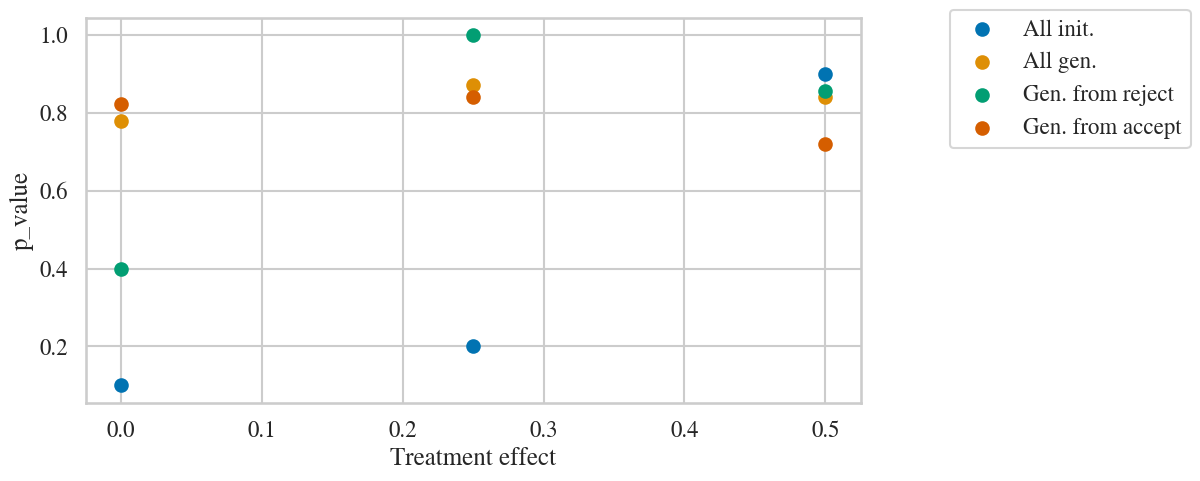

In [17]:
puiss_init = results.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
puiss_gen = results.groupby("H0_coef").mean()["reject_H0_gen"].to_numpy()
# puiss_among_reject = results[results["reject_H0_init"] ==  True].groupby(["H0_coef"]).mean()["reject_H0_gen"].to_numpy()
tmp = results[results["reject_H0_init"] ==  True].groupby(["H0_coef"])["reject_H0_gen"].mean().to_dict()
results["puiss_among_reject"] = results["H0_coef"].map(tmp)
puiss_among_reject = results[["H0_coef", "puiss_among_reject"]].drop_duplicates()["puiss_among_reject"].values

# puiss_among_accept = results[results["reject_H0_init"] ==  False].groupby(["H0_coef"]).mean()["reject_H0_gen"].to_numpy()
tmp = results[results["reject_H0_init"] ==  False].groupby(["H0_coef"])["reject_H0_gen"].mean().to_dict()
results["puiss_among_accept"] = results["H0_coef"].map(tmp)
puiss_among_accept = results[["H0_coef", "puiss_among_accept"]].drop_duplicates()["puiss_among_accept"].values


plt.figure(figsize=(10, 5))
plt.scatter(treatment_effects, puiss_init, label = "All init.")
plt.scatter(treatment_effects, puiss_gen, label = "All gen.")
plt.scatter(treatment_effects, puiss_among_reject, label = "Gen. from reject")
plt.scatter(treatment_effects, puiss_among_accept, label = "Gen. from accept")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel("Treatment effect")
plt.ylabel("p_value")
plt.show()

# Monte Carlo XP

In [18]:
n_generated_dataset = 50
dataset_name = "Simulations"

In [19]:
treat_effects = np.arange(0, 1.1, 0.4)
print("Treatment effects", treat_effects)

Treatment effects [0.  0.4 0.8]


## Independent

In [64]:
M = 10
log_p_value = []
log_p_value_gen_hivae = []
log_p_value_gen_survgan = []
log_p_value_gen_survvae = []
simu_num = []
H0_coef = []
for t in treat_effects:
    treatment_effect = t
    print("treatment_effect",treatment_effect)
    for m in np.arange(M):
        if m % 10 == 0:
            print(m)
        control, treated, types = simulation(beta_features , treatment_effect , n_samples,surv_type = "surv_piecewise      ")
        control = control.drop(columns='treatment')
        treated = treated.drop(columns='treatment')
        
        data_file_control= "./dataset/" + dataset_name + "/data_control_gen.csv"
       
        control.to_csv(data_file_control,index=False , header=False)

        
        T_surv = torch.Tensor(df_init_control.time)
        T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
        n_intervals = 5
        T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
        T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
        intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]
        
        p_value_init = compute_logrank_test(control, treated)
    
        
    
        # Load and transform control data
        data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                             feat_types_file_control, 
                                                                                                             miss_file, true_miss_file,
                                                                                                             surv_type = "surv_piecewise")
        data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)
   
        data_gen_control_hivae = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, 
                                      true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_dataset, verbose=False)
        
        data_gen_control_survgan = surv_gan.run(data_init_control, columns=fnames, target_column="censor", 
                                time_to_event_column="time", n_generated_sample=n_generated_dataset)


        data_gen_control_survvae = surv_vae.run(data_init_control, columns=fnames, target_column="censor", 
                                time_to_event_column="time", n_generated_sample=n_generated_dataset)
        
        
        
        for i in range(n_generated_dataset):
            df_gen_control_hivae = pd.DataFrame(data_gen_control_hivae[i].numpy(), columns=fnames)

            df_gen_control_survgan = pd.DataFrame(data_gen_control_survgan[i].numpy(), columns=fnames)

            df_gen_control_survvae = pd.DataFrame(data_gen_control_survvae[i].numpy(), columns=fnames)

            log_p_value.append(p_value_init)
            simu_num.append(m)
            p_value_gen_hivae = compute_logrank_test(df_gen_control_hivae, treated)
            p_value_gen_survgan = compute_logrank_test(df_gen_control_survgan, treated)
            p_value_gen_survvae = compute_logrank_test(df_gen_control_survvae, treated)
    
      
            log_p_value_gen_hivae.append(p_value_gen_hivae)
            log_p_value_gen_survgan.append(p_value_gen_survgan)
            log_p_value_gen_survvae.append(p_value_gen_survvae)
            H0_coef.append(treatment_effect)


0
Epoch: [ 0]  time: 0.0195, ELBO_train: -14.78657484, KL_z: 2.00066745, KL_s: 0.10466361, reconstruction loss: -12.68124378
Epoch: [100]  time: 1.1708, ELBO_train: -12.02682018, KL_z: 0.82098821, KL_s: 0.04974377, reconstruction loss: -11.15608820
Epoch: [200]  time: 2.3505, ELBO_train: -11.83521366, KL_z: 1.07033962, KL_s: 0.04344261, reconstruction loss: -10.72143143
Epoch: [300]  time: 3.5962, ELBO_train: -11.43104649, KL_z: 1.23761797, KL_s: 0.04335845, reconstruction loss: -10.15007007
Epoch: [400]  time: 4.8714, ELBO_train: -11.66573000, KL_z: 1.36595941, KL_s: 0.04776406, reconstruction loss: -10.25200653
Epoch: [500]  time: 6.2378, ELBO_train: -11.44892693, KL_z: 1.46330762, KL_s: 0.05064821, reconstruction loss: -9.93497109
Epoch: [600]  time: 7.6121, ELBO_train: -11.15658188, KL_z: 1.57254875, KL_s: 0.05220580, reconstruction loss: -9.53182733
Epoch: [700]  time: 8.9661, ELBO_train: -11.32949829, KL_z: 1.63059461, KL_s: 0.05444610, reconstruction loss: -9.64445758
Epoch: [80

[2025-05-26T12:08:14.805974+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:08:14.862432+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Training finished.
{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


  3%|█▎                                     | 349/10000 [00:13<06:18, 25.53it/s]
[2025-05-26T12:08:29.141937+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:08:29.155282+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 35%|██████████████                          | 350/1000 [00:17<00:31, 20.34it/s]


Epoch: [ 0]  time: 0.0171, ELBO_train: -14.80580473, KL_z: 1.90021783, KL_s: 0.09195280, reconstruction loss: -12.81363410
Epoch: [100]  time: 1.5409, ELBO_train: -11.81552267, KL_z: 0.82698309, KL_s: 0.05150926, reconstruction loss: -10.93703032
Epoch: [200]  time: 3.0046, ELBO_train: -11.47115850, KL_z: 1.04615265, KL_s: 0.03449321, reconstruction loss: -10.39051265
Epoch: [300]  time: 4.4546, ELBO_train: -11.02983522, KL_z: 1.28939766, KL_s: 0.03906143, reconstruction loss: -9.70137614
Epoch: [400]  time: 5.9419, ELBO_train: -10.96832228, KL_z: 1.44091171, KL_s: 0.04061019, reconstruction loss: -9.48680037
Epoch: [500]  time: 7.4263, ELBO_train: -11.10825825, KL_z: 1.54988980, KL_s: 0.04049611, reconstruction loss: -9.51787233
Epoch: [600]  time: 8.8805, ELBO_train: -10.90440130, KL_z: 1.62956727, KL_s: 0.04090500, reconstruction loss: -9.23392904
Epoch: [700]  time: 10.3752, ELBO_train: -10.81021881, KL_z: 1.70986331, KL_s: 0.03967440, reconstruction loss: -9.06068110
Epoch: [800] 

[2025-05-26T12:09:01.992756+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:09:02.052871+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Training finished.
{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


  5%|█▉                                     | 499/10000 [00:20<06:29, 24.37it/s]
[2025-05-26T12:09:23.205723+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:09:23.221531+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 50%|████████████████████                    | 500/1000 [00:27<00:27, 18.41it/s]


Epoch: [ 0]  time: 0.0195, ELBO_train: -14.78818989, KL_z: 1.96879888, KL_s: 0.09977436, reconstruction loss: -12.71961665
Epoch: [100]  time: 1.8310, ELBO_train: -11.56092930, KL_z: 0.72618043, KL_s: 0.04761684, reconstruction loss: -10.78713202
Epoch: [200]  time: 3.5659, ELBO_train: -11.30350399, KL_z: 1.02072698, KL_s: 0.03916848, reconstruction loss: -10.24360853
Epoch: [300]  time: 5.2621, ELBO_train: -10.97177076, KL_z: 1.18911386, KL_s: 0.03961241, reconstruction loss: -9.74304450
Epoch: [400]  time: 6.9775, ELBO_train: -10.95310640, KL_z: 1.35671413, KL_s: 0.04258287, reconstruction loss: -9.55380940
Epoch: [500]  time: 8.8000, ELBO_train: -10.84105730, KL_z: 1.51310587, KL_s: 0.04524899, reconstruction loss: -9.28270245
Epoch: [600]  time: 10.6294, ELBO_train: -11.36130714, KL_z: 1.58281994, KL_s: 0.04505658, reconstruction loss: -9.73343062
Epoch: [700]  time: 12.3397, ELBO_train: -10.89120054, KL_z: 1.64495015, KL_s: 0.04654479, reconstruction loss: -9.19970560
Epoch: [800]

[2025-05-26T12:10:08.989246+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:10:09.063784+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Training finished.
{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


  4%|█▊                                     | 449/10000 [00:19<06:54, 23.03it/s]
[2025-05-26T12:10:29.320601+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:10:29.336657+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 50%|████████████████████                    | 500/1000 [00:27<00:27, 18.49it/s]


Epoch: [ 0]  time: 0.0218, ELBO_train: -14.87828922, KL_z: 1.93439871, KL_s: 0.11663210, reconstruction loss: -12.82725841
Epoch: [100]  time: 1.9231, ELBO_train: -11.67214298, KL_z: 0.85745555, KL_s: 0.04270422, reconstruction loss: -10.77198321
Epoch: [200]  time: 3.7243, ELBO_train: -11.14924955, KL_z: 1.10647273, KL_s: 0.03423095, reconstruction loss: -10.00854588
Epoch: [300]  time: 5.4770, ELBO_train: -11.34238291, KL_z: 1.29347527, KL_s: 0.03465402, reconstruction loss: -10.01425362
Epoch: [400]  time: 7.2075, ELBO_train: -11.01443148, KL_z: 1.43183506, KL_s: 0.04004300, reconstruction loss: -9.54255342
Epoch: [500]  time: 8.9230, ELBO_train: -11.03551006, KL_z: 1.56684244, KL_s: 0.04113555, reconstruction loss: -9.42753208
Epoch: [600]  time: 10.5942, ELBO_train: -10.77317905, KL_z: 1.68964732, KL_s: 0.04172480, reconstruction loss: -9.04180694
Epoch: [700]  time: 12.2856, ELBO_train: -10.80098915, KL_z: 1.71809453, KL_s: 0.03991663, reconstruction loss: -9.04297799
Epoch: [800

[2025-05-26T12:11:14.744699+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:11:14.793787+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Training finished.
{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


 11%|████▏                                 | 1099/10000 [00:48<06:35, 22.53it/s]
[2025-05-26T12:12:04.318908+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:12:04.337683+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|██████████████████                      | 450/1000 [00:25<00:31, 17.61it/s]


Epoch: [ 0]  time: 0.0202, ELBO_train: -14.36908531, KL_z: 1.82365036, KL_s: 0.10903203, reconstruction loss: -12.43640292
Epoch: [100]  time: 1.8222, ELBO_train: -11.88992119, KL_z: 0.93463853, KL_s: 0.04338229, reconstruction loss: -10.91190037
Epoch: [200]  time: 3.4497, ELBO_train: -11.24154329, KL_z: 1.15759617, KL_s: 0.03224647, reconstruction loss: -10.05170065
Epoch: [300]  time: 5.0808, ELBO_train: -11.15640640, KL_z: 1.26371169, KL_s: 0.03705072, reconstruction loss: -9.85564399
Epoch: [400]  time: 6.7200, ELBO_train: -11.16513729, KL_z: 1.39445227, KL_s: 0.03895259, reconstruction loss: -9.73173243
Epoch: [500]  time: 8.3532, ELBO_train: -11.12966013, KL_z: 1.54315430, KL_s: 0.04264784, reconstruction loss: -9.54385799
Epoch: [600]  time: 10.0298, ELBO_train: -11.11795855, KL_z: 1.58218080, KL_s: 0.04316044, reconstruction loss: -9.49261731
Epoch: [700]  time: 11.6511, ELBO_train: -10.82469797, KL_z: 1.64047891, KL_s: 0.04294550, reconstruction loss: -9.14127356
Epoch: [800]

[2025-05-26T12:12:47.499027+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:12:47.568025+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Training finished.
{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


  6%|██▌                                    | 649/10000 [00:29<07:00, 22.22it/s]
[2025-05-26T12:13:17.537329+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:13:17.553388+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|██████████████████                      | 450/1000 [00:25<00:30, 17.95it/s]


Epoch: [ 0]  time: 0.0196, ELBO_train: -14.71073294, KL_z: 1.90019172, KL_s: 0.11541533, reconstruction loss: -12.69512588
Epoch: [100]  time: 1.7922, ELBO_train: -11.58162594, KL_z: 0.88509917, KL_s: 0.04872215, reconstruction loss: -10.64780462
Epoch: [200]  time: 3.5493, ELBO_train: -10.98882627, KL_z: 1.11852807, KL_s: 0.03501058, reconstruction loss: -9.83528763
Epoch: [300]  time: 5.2918, ELBO_train: -10.94804382, KL_z: 1.31676620, KL_s: 0.03620923, reconstruction loss: -9.59506840
Epoch: [400]  time: 6.9874, ELBO_train: -10.73294544, KL_z: 1.39551514, KL_s: 0.03773546, reconstruction loss: -9.29969484
Epoch: [500]  time: 8.6372, ELBO_train: -10.97962427, KL_z: 1.49490964, KL_s: 0.03777480, reconstruction loss: -9.44693983
Epoch: [600]  time: 10.2806, ELBO_train: -10.59521580, KL_z: 1.63084310, KL_s: 0.04183924, reconstruction loss: -8.92253345
Epoch: [700]  time: 11.9102, ELBO_train: -10.96267462, KL_z: 1.78108048, KL_s: 0.04276049, reconstruction loss: -9.13883364
Epoch: [800] 

[2025-05-26T12:14:00.473499+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:14:00.523250+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Training finished.
{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


  7%|██▉                                    | 749/10000 [00:32<06:39, 23.16it/s]
[2025-05-26T12:14:33.641989+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:14:33.658905+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 35%|██████████████                          | 350/1000 [00:19<00:36, 17.85it/s]


Epoch: [ 0]  time: 0.0193, ELBO_train: -14.64846945, KL_z: 1.80465615, KL_s: 0.11678457, reconstruction loss: -12.72702873
Epoch: [100]  time: 1.7909, ELBO_train: -11.92426300, KL_z: 0.83751741, KL_s: 0.04333603, reconstruction loss: -11.04340956
Epoch: [200]  time: 3.4174, ELBO_train: -11.63358593, KL_z: 1.09217620, KL_s: 0.03101707, reconstruction loss: -10.51039267
Epoch: [300]  time: 5.0455, ELBO_train: -11.36045742, KL_z: 1.18071371, KL_s: 0.03511965, reconstruction loss: -10.14462405
Epoch: [400]  time: 6.6838, ELBO_train: -10.98431301, KL_z: 1.32952929, KL_s: 0.03673601, reconstruction loss: -9.61804771
Epoch: [500]  time: 8.3307, ELBO_train: -10.93742180, KL_z: 1.45995462, KL_s: 0.03762293, reconstruction loss: -9.43984425
Epoch: [600]  time: 9.9763, ELBO_train: -11.00084877, KL_z: 1.62090141, KL_s: 0.04071927, reconstruction loss: -9.33922809
Epoch: [700]  time: 11.6413, ELBO_train: -10.90298605, KL_z: 1.73369759, KL_s: 0.04010594, reconstruction loss: -9.12918252
Epoch: [800]

[2025-05-26T12:15:10.913341+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:15:10.980802+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Training finished.
{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


 10%|███▉                                   | 999/10000 [00:45<06:49, 21.99it/s]
[2025-05-26T12:15:57.162646+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:15:57.178034+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|██████████████████                      | 450/1000 [00:24<00:29, 18.53it/s]


Epoch: [ 0]  time: 0.0202, ELBO_train: -14.86220026, KL_z: 1.93054622, KL_s: 0.11117828, reconstruction loss: -12.82047576
Epoch: [100]  time: 1.8198, ELBO_train: -11.99135590, KL_z: 0.86295182, KL_s: 0.04249966, reconstruction loss: -11.08590442
Epoch: [200]  time: 3.4894, ELBO_train: -11.43280602, KL_z: 1.15142655, KL_s: 0.02732360, reconstruction loss: -10.25405586
Epoch: [300]  time: 5.1270, ELBO_train: -11.29249239, KL_z: 1.30908114, KL_s: 0.02683449, reconstruction loss: -9.95657676
Epoch: [400]  time: 6.7853, ELBO_train: -11.42082262, KL_z: 1.45415080, KL_s: 0.02728200, reconstruction loss: -9.93938982
Epoch: [500]  time: 8.4207, ELBO_train: -11.30654669, KL_z: 1.55577910, KL_s: 0.02792645, reconstruction loss: -9.72284114
Epoch: [600]  time: 10.1698, ELBO_train: -11.15832233, KL_z: 1.66147923, KL_s: 0.02911091, reconstruction loss: -9.46773219
Epoch: [700]  time: 11.9301, ELBO_train: -11.16481543, KL_z: 1.74967700, KL_s: 0.03037000, reconstruction loss: -9.38476843
Epoch: [800]

[2025-05-26T12:16:39.513811+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:16:39.583588+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Training finished.
{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


  4%|█▊                                     | 449/10000 [00:19<06:48, 23.37it/s]
[2025-05-26T12:16:59.686042+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:16:59.715983+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 65%|██████████████████████████              | 650/1000 [00:34<00:18, 18.59it/s]


Epoch: [ 0]  time: 0.0185, ELBO_train: -14.87249231, KL_z: 2.10222685, KL_s: 0.09431279, reconstruction loss: -12.67595267
Epoch: [100]  time: 1.8175, ELBO_train: -11.78111172, KL_z: 0.91545251, KL_s: 0.05146897, reconstruction loss: -10.81419024
Epoch: [200]  time: 3.5350, ELBO_train: -11.52652454, KL_z: 1.18180603, KL_s: 0.03826010, reconstruction loss: -10.30645841
Epoch: [300]  time: 5.2357, ELBO_train: -11.14079189, KL_z: 1.33372748, KL_s: 0.04086518, reconstruction loss: -9.76619923
Epoch: [400]  time: 7.0241, ELBO_train: -10.82095385, KL_z: 1.47974062, KL_s: 0.04476810, reconstruction loss: -9.29644513
Epoch: [500]  time: 8.7154, ELBO_train: -11.25538492, KL_z: 1.59608060, KL_s: 0.04743624, reconstruction loss: -9.61186808
Epoch: [600]  time: 10.3591, ELBO_train: -10.71177006, KL_z: 1.69825822, KL_s: 0.04856420, reconstruction loss: -8.96494764
Epoch: [700]  time: 12.0409, ELBO_train: -10.94522953, KL_z: 1.80343759, KL_s: 0.04889834, reconstruction loss: -9.09289360
Epoch: [800]

[2025-05-26T12:17:52.909367+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:17:52.982231+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Training finished.
{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


  5%|██▏                                    | 549/10000 [00:26<07:38, 20.61it/s]
[2025-05-26T12:18:20.604687+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:18:20.621606+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 35%|██████████████                          | 350/1000 [00:20<00:37, 17.47it/s]


Epoch: [ 0]  time: 0.0178, ELBO_train: -14.38590765, KL_z: 1.72009820, KL_s: 0.11320841, reconstruction loss: -12.55260104
Epoch: [100]  time: 1.7065, ELBO_train: -11.62888241, KL_z: 0.86295417, KL_s: 0.04712832, reconstruction loss: -10.71879992
Epoch: [200]  time: 3.3405, ELBO_train: -11.63835955, KL_z: 1.15416682, KL_s: 0.02777290, reconstruction loss: -10.45641983
Epoch: [300]  time: 4.9837, ELBO_train: -11.49408102, KL_z: 1.29698515, KL_s: 0.02932394, reconstruction loss: -10.16777194
Epoch: [400]  time: 6.6192, ELBO_train: -11.16503572, KL_z: 1.44523543, KL_s: 0.02991974, reconstruction loss: -9.68988055
Epoch: [500]  time: 8.3761, ELBO_train: -10.89526796, KL_z: 1.54909760, KL_s: 0.02945936, reconstruction loss: -9.31671101
Epoch: [600]  time: 10.0738, ELBO_train: -10.84215927, KL_z: 1.67254514, KL_s: 0.03194416, reconstruction loss: -9.13766998
Epoch: [700]  time: 11.7453, ELBO_train: -10.83570528, KL_z: 1.69498056, KL_s: 0.03003991, reconstruction loss: -9.11068481
Epoch: [800

[2025-05-26T12:18:58.455013+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:18:58.506279+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Training finished.
{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


  7%|██▋                                    | 699/10000 [00:31<06:54, 22.43it/s]
[2025-05-26T12:19:30.409934+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:19:30.426876+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 35%|██████████████                          | 350/1000 [00:20<00:37, 17.30it/s]


0
Epoch: [ 0]  time: 0.0191, ELBO_train: -14.77914762, KL_z: 1.80261421, KL_s: 0.10724616, reconstruction loss: -12.86928725
Epoch: [100]  time: 1.8207, ELBO_train: -11.98319340, KL_z: 0.90187189, KL_s: 0.04807639, reconstruction loss: -11.03324512
Epoch: [200]  time: 3.4947, ELBO_train: -11.53276014, KL_z: 1.14644843, KL_s: 0.04167712, reconstruction loss: -10.34463459
Epoch: [300]  time: 5.1506, ELBO_train: -11.39200830, KL_z: 1.34159750, KL_s: 0.04182959, reconstruction loss: -10.00858122
Epoch: [400]  time: 6.8181, ELBO_train: -11.43977880, KL_z: 1.50182581, KL_s: 0.04334962, reconstruction loss: -9.89460337
Epoch: [500]  time: 8.5167, ELBO_train: -11.28906488, KL_z: 1.60334033, KL_s: 0.04336274, reconstruction loss: -9.64236182
Epoch: [600]  time: 10.1872, ELBO_train: -11.14478445, KL_z: 1.70813078, KL_s: 0.04517555, reconstruction loss: -9.39147812
Epoch: [700]  time: 11.8434, ELBO_train: -11.51792622, KL_z: 1.78287953, KL_s: 0.04361403, reconstruction loss: -9.69143265
Epoch: [8

[2025-05-26T12:20:08.550392+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:20:08.618950+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Training finished.
{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


  7%|██▋                                    | 699/10000 [00:30<06:40, 23.23it/s]
[2025-05-26T12:20:39.421734+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:20:39.437980+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 75%|██████████████████████████████          | 750/1000 [00:40<00:13, 18.42it/s]


Epoch: [ 0]  time: 0.0249, ELBO_train: -14.42746401, KL_z: 2.04952598, KL_s: 0.10030162, reconstruction loss: -12.27763641
Epoch: [100]  time: 1.7188, ELBO_train: -11.61051893, KL_z: 0.85942888, KL_s: 0.04980588, reconstruction loss: -10.70128417
Epoch: [200]  time: 3.3793, ELBO_train: -11.25522566, KL_z: 1.09106332, KL_s: 0.03843594, reconstruction loss: -10.12572640
Epoch: [300]  time: 5.1309, ELBO_train: -11.38410187, KL_z: 1.29724628, KL_s: 0.03647625, reconstruction loss: -10.05037934
Epoch: [400]  time: 6.9122, ELBO_train: -11.01162529, KL_z: 1.40673751, KL_s: 0.03730404, reconstruction loss: -9.56758374
Epoch: [500]  time: 8.6476, ELBO_train: -11.15096951, KL_z: 1.51671088, KL_s: 0.03853893, reconstruction loss: -9.59571970
Epoch: [600]  time: 10.4200, ELBO_train: -10.98694468, KL_z: 1.61212909, KL_s: 0.03930926, reconstruction loss: -9.33550632
Epoch: [700]  time: 12.1918, ELBO_train: -10.57812357, KL_z: 1.67321563, KL_s: 0.04040337, reconstruction loss: -8.86450458
Epoch: [800

[2025-05-26T12:21:38.786071+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:21:38.863386+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Training finished.
{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


  8%|███▎                                   | 849/10000 [00:39<07:07, 21.41it/s]
[2025-05-26T12:22:19.277881+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:22:19.294093+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 40%|████████████████                        | 400/1000 [00:22<00:33, 18.12it/s]


Epoch: [ 0]  time: 0.0182, ELBO_train: -15.40480804, KL_z: 1.96479148, KL_s: 0.11751139, reconstruction loss: -13.32250518
Epoch: [100]  time: 1.7990, ELBO_train: -12.08576918, KL_z: 0.88018572, KL_s: 0.04850006, reconstruction loss: -11.15708339
Epoch: [200]  time: 3.5019, ELBO_train: -11.64406490, KL_z: 1.10123491, KL_s: 0.03795803, reconstruction loss: -10.50487196
Epoch: [300]  time: 5.1564, ELBO_train: -11.65174866, KL_z: 1.29378712, KL_s: 0.04076409, reconstruction loss: -10.31719744
Epoch: [400]  time: 6.9160, ELBO_train: -11.54360819, KL_z: 1.45973724, KL_s: 0.04324710, reconstruction loss: -10.04062384
Epoch: [500]  time: 8.5973, ELBO_train: -11.67995739, KL_z: 1.62257373, KL_s: 0.04201937, reconstruction loss: -10.01536429
Epoch: [600]  time: 10.2707, ELBO_train: -11.39434862, KL_z: 1.67655796, KL_s: 0.04673445, reconstruction loss: -9.67105621
Epoch: [700]  time: 11.9632, ELBO_train: -11.39664984, KL_z: 1.73909605, KL_s: 0.04383492, reconstruction loss: -9.61371887
Epoch: [8

[2025-05-26T12:22:59.356608+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:22:59.415938+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Training finished.
{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


  6%|██▌                                    | 649/10000 [00:28<06:53, 22.64it/s]
[2025-05-26T12:23:28.823200+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:23:28.839335+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|██████████████████                      | 450/1000 [00:23<00:28, 19.33it/s]


Epoch: [ 0]  time: 0.0177, ELBO_train: -15.20967722, KL_z: 2.03736806, KL_s: 0.11990249, reconstruction loss: -13.05240667
Epoch: [100]  time: 1.8408, ELBO_train: -12.04277325, KL_z: 0.82858700, KL_s: 0.04546702, reconstruction loss: -11.16871923
Epoch: [200]  time: 3.6616, ELBO_train: -11.96489191, KL_z: 1.01571286, KL_s: 0.03809536, reconstruction loss: -10.91108370
Epoch: [300]  time: 5.3221, ELBO_train: -11.76736593, KL_z: 1.17641050, KL_s: 0.03980315, reconstruction loss: -10.55115229
Epoch: [400]  time: 7.1055, ELBO_train: -11.43876696, KL_z: 1.33385628, KL_s: 0.03965151, reconstruction loss: -10.06525916
Epoch: [500]  time: 8.8520, ELBO_train: -11.53015566, KL_z: 1.49348694, KL_s: 0.04145348, reconstruction loss: -9.99521524
Epoch: [600]  time: 10.6226, ELBO_train: -11.35869551, KL_z: 1.59106290, KL_s: 0.03836823, reconstruction loss: -9.72926438
Epoch: [700]  time: 12.3580, ELBO_train: -11.44076300, KL_z: 1.64449322, KL_s: 0.03975391, reconstruction loss: -9.75651586
Epoch: [80

[2025-05-26T12:24:10.574157+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:24:10.632025+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Training finished.
{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


  3%|█▎                                     | 349/10000 [00:14<06:43, 23.91it/s]
[2025-05-26T12:24:25.996565+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:24:26.012541+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 60%|████████████████████████                | 600/1000 [00:33<00:22, 18.02it/s]


Epoch: [ 0]  time: 0.0189, ELBO_train: -14.90787506, KL_z: 2.19915128, KL_s: 0.10263371, reconstruction loss: -12.60609007
Epoch: [100]  time: 1.8565, ELBO_train: -11.82259178, KL_z: 0.84903413, KL_s: 0.04643738, reconstruction loss: -10.92712027
Epoch: [200]  time: 3.5924, ELBO_train: -11.78424549, KL_z: 1.09851331, KL_s: 0.03255892, reconstruction loss: -10.65317327
Epoch: [300]  time: 5.3833, ELBO_train: -11.41004658, KL_z: 1.24951649, KL_s: 0.03697348, reconstruction loss: -10.12355661
Epoch: [400]  time: 7.1569, ELBO_train: -11.25774479, KL_z: 1.41184151, KL_s: 0.03626812, reconstruction loss: -9.80963516
Epoch: [500]  time: 8.8939, ELBO_train: -10.90802383, KL_z: 1.49638504, KL_s: 0.03897822, reconstruction loss: -9.37266058
Epoch: [600]  time: 10.7109, ELBO_train: -11.19766283, KL_z: 1.59586579, KL_s: 0.04048729, reconstruction loss: -9.56130975
Epoch: [700]  time: 12.4695, ELBO_train: -10.77778912, KL_z: 1.67691827, KL_s: 0.04019964, reconstruction loss: -9.06067121
Epoch: [800

[2025-05-26T12:25:17.973551+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:25:18.031185+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Training finished.
{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


  9%|███▌                                   | 899/10000 [00:39<06:37, 22.89it/s]
[2025-05-26T12:25:58.079552+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:25:58.095608+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 55%|██████████████████████                  | 550/1000 [00:30<00:25, 17.80it/s]


Epoch: [ 0]  time: 0.0206, ELBO_train: -14.28707266, KL_z: 1.84364253, KL_s: 0.09373343, reconstruction loss: -12.34969670
Epoch: [100]  time: 1.8596, ELBO_train: -11.79031563, KL_z: 0.78015608, KL_s: 0.05508494, reconstruction loss: -10.95507461
Epoch: [200]  time: 3.6891, ELBO_train: -11.10491371, KL_z: 1.11664003, KL_s: 0.04416645, reconstruction loss: -9.94410723
Epoch: [300]  time: 5.5071, ELBO_train: -10.96121311, KL_z: 1.30361664, KL_s: 0.04372847, reconstruction loss: -9.61386800
Epoch: [400]  time: 7.1799, ELBO_train: -10.67389107, KL_z: 1.45489037, KL_s: 0.04340804, reconstruction loss: -9.17559266
Epoch: [500]  time: 9.0288, ELBO_train: -10.87497807, KL_z: 1.58187878, KL_s: 0.04323184, reconstruction loss: -9.24986744
Epoch: [600]  time: 11.0454, ELBO_train: -11.06081963, KL_z: 1.64437932, KL_s: 0.04899013, reconstruction loss: -9.36745018
Epoch: [700]  time: 12.8215, ELBO_train: -10.71559477, KL_z: 1.72656792, KL_s: 0.05051470, reconstruction loss: -8.93851215
Epoch: [800] 

[2025-05-26T12:26:48.152463+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:26:48.214569+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Training finished.
{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


  8%|███                                    | 799/10000 [00:35<06:49, 22.46it/s]
[2025-05-26T12:27:24.499174+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:27:24.515197+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 50%|████████████████████                    | 500/1000 [00:28<00:28, 17.79it/s]


Epoch: [ 0]  time: 0.0220, ELBO_train: -14.87828922, KL_z: 1.93439871, KL_s: 0.11663210, reconstruction loss: -12.82725841
Epoch: [100]  time: 1.8200, ELBO_train: -11.67214298, KL_z: 0.85745555, KL_s: 0.04270422, reconstruction loss: -10.77198321
Epoch: [200]  time: 3.6472, ELBO_train: -11.14924955, KL_z: 1.10647273, KL_s: 0.03423095, reconstruction loss: -10.00854588
Epoch: [300]  time: 5.3894, ELBO_train: -11.34238291, KL_z: 1.29347527, KL_s: 0.03465402, reconstruction loss: -10.01425362
Epoch: [400]  time: 7.0745, ELBO_train: -11.01443148, KL_z: 1.43183506, KL_s: 0.04004300, reconstruction loss: -9.54255342
Epoch: [500]  time: 8.7818, ELBO_train: -11.03551006, KL_z: 1.56684244, KL_s: 0.04113555, reconstruction loss: -9.42753208
Epoch: [600]  time: 10.4718, ELBO_train: -10.77317905, KL_z: 1.68964732, KL_s: 0.04172480, reconstruction loss: -9.04180694
Epoch: [700]  time: 12.1939, ELBO_train: -10.80098915, KL_z: 1.71809453, KL_s: 0.03991663, reconstruction loss: -9.04297799
Epoch: [800

[2025-05-26T12:28:10.936984+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:28:10.979577+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Training finished.
{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


  8%|███                                    | 799/10000 [00:38<07:21, 20.83it/s]
[2025-05-26T12:28:50.135980+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:28:50.151687+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|██████████████████                      | 450/1000 [00:26<00:31, 17.27it/s]


Epoch: [ 0]  time: 0.0212, ELBO_train: -14.36908531, KL_z: 1.82365036, KL_s: 0.10903203, reconstruction loss: -12.43640292
Epoch: [100]  time: 1.8294, ELBO_train: -11.88992119, KL_z: 0.93463853, KL_s: 0.04338229, reconstruction loss: -10.91190037
Epoch: [200]  time: 3.5720, ELBO_train: -11.24154329, KL_z: 1.15759617, KL_s: 0.03224647, reconstruction loss: -10.05170065
Epoch: [300]  time: 5.2514, ELBO_train: -11.15640640, KL_z: 1.26371169, KL_s: 0.03705072, reconstruction loss: -9.85564399
Epoch: [400]  time: 6.9708, ELBO_train: -11.16513729, KL_z: 1.39445227, KL_s: 0.03895259, reconstruction loss: -9.73173243
Epoch: [500]  time: 8.6833, ELBO_train: -11.12966013, KL_z: 1.54315430, KL_s: 0.04264784, reconstruction loss: -9.54385799
Epoch: [600]  time: 10.5025, ELBO_train: -11.11795855, KL_z: 1.58218080, KL_s: 0.04316044, reconstruction loss: -9.49261731
Epoch: [700]  time: 12.2859, ELBO_train: -10.82469797, KL_z: 1.64047891, KL_s: 0.04294550, reconstruction loss: -9.14127356
Epoch: [800]

[2025-05-26T12:29:34.541111+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:29:34.611713+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Training finished.
{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


  6%|██▌                                    | 649/10000 [00:29<07:03, 22.10it/s]
[2025-05-26T12:30:04.742751+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:30:04.758612+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|██████████████████                      | 450/1000 [00:25<00:31, 17.68it/s]


Epoch: [ 0]  time: 0.0187, ELBO_train: -14.71073294, KL_z: 1.90019172, KL_s: 0.11541533, reconstruction loss: -12.69512588
Epoch: [100]  time: 1.8173, ELBO_train: -11.58162594, KL_z: 0.88509917, KL_s: 0.04872215, reconstruction loss: -10.64780462
Epoch: [200]  time: 3.5742, ELBO_train: -10.98882627, KL_z: 1.11852807, KL_s: 0.03501058, reconstruction loss: -9.83528763
Epoch: [300]  time: 5.2585, ELBO_train: -10.94804382, KL_z: 1.31676620, KL_s: 0.03620923, reconstruction loss: -9.59506840
Epoch: [400]  time: 6.9753, ELBO_train: -10.73294544, KL_z: 1.39551514, KL_s: 0.03773546, reconstruction loss: -9.29969484
Epoch: [500]  time: 8.6886, ELBO_train: -10.97962427, KL_z: 1.49490964, KL_s: 0.03777480, reconstruction loss: -9.44693983
Epoch: [600]  time: 10.4337, ELBO_train: -10.59521580, KL_z: 1.63084310, KL_s: 0.04183924, reconstruction loss: -8.92253345
Epoch: [700]  time: 12.1592, ELBO_train: -10.96267462, KL_z: 1.78108048, KL_s: 0.04276049, reconstruction loss: -9.13883364
Epoch: [800] 

[2025-05-26T12:30:48.551092+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:30:48.602102+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Training finished.
{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


 12%|████▌                                 | 1199/10000 [00:52<06:24, 22.89it/s]
[2025-05-26T12:31:41.775300+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:31:41.793974+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 35%|██████████████                          | 350/1000 [00:20<00:37, 17.31it/s]


Epoch: [ 0]  time: 0.0187, ELBO_train: -14.64846945, KL_z: 1.80465615, KL_s: 0.11678457, reconstruction loss: -12.72702873
Epoch: [100]  time: 1.8538, ELBO_train: -11.92426300, KL_z: 0.83751741, KL_s: 0.04333603, reconstruction loss: -11.04340956
Epoch: [200]  time: 3.6206, ELBO_train: -11.63358593, KL_z: 1.09217620, KL_s: 0.03101707, reconstruction loss: -10.51039267
Epoch: [300]  time: 5.3389, ELBO_train: -11.36045742, KL_z: 1.18071371, KL_s: 0.03511965, reconstruction loss: -10.14462405
Epoch: [400]  time: 7.0819, ELBO_train: -10.98431301, KL_z: 1.32952929, KL_s: 0.03673601, reconstruction loss: -9.61804771
Epoch: [500]  time: 8.7865, ELBO_train: -10.93742180, KL_z: 1.45995462, KL_s: 0.03762293, reconstruction loss: -9.43984425
Epoch: [600]  time: 10.5082, ELBO_train: -11.00084877, KL_z: 1.62090141, KL_s: 0.04071927, reconstruction loss: -9.33922809
Epoch: [700]  time: 12.2186, ELBO_train: -10.90298605, KL_z: 1.73369759, KL_s: 0.04010594, reconstruction loss: -9.12918252
Epoch: [800

[2025-05-26T12:32:20.452414+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:32:20.521132+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Training finished.
{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


 12%|████▌                                 | 1199/10000 [00:53<06:30, 22.53it/s]
[2025-05-26T12:33:14.476622+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-26T12:33:14.495778+0200][15941][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|██████████████████                      | 450/1000 [00:25<00:31, 17.48it/s]


In [20]:

results = pd.DataFrame({'XP_num' : simu_num, "log_pvalue_init" : log_p_value, "log_pvalue_gen_hivae" : log_p_value_gen_hivae,
                        "log_pvalue_gen_survgan" : log_p_value_gen_survgan ,
                        "log_pvalue_gen_survvae" : log_p_value_gen_survvae ,
                        "H0_coef" : H0_coef})
results["reject_H0_init"] = results['log_pvalue_init'] > -np.log(0.05)
results["reject_H0_gen_hivae"] = results['log_pvalue_gen_hivae'] > -np.log(0.05)
results["reject_H0_gen_survgan"] = results['log_pvalue_gen_survgan'] > -np.log(0.05)
results["reject_H0_gen_survvae"] = results['log_pvalue_gen_survvae'] > -np.log(0.05)

results.to_csv("./dataset/" + dataset_name + "results_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".csv")

NameError: name 'log_p_value_gen_hivae' is not defined

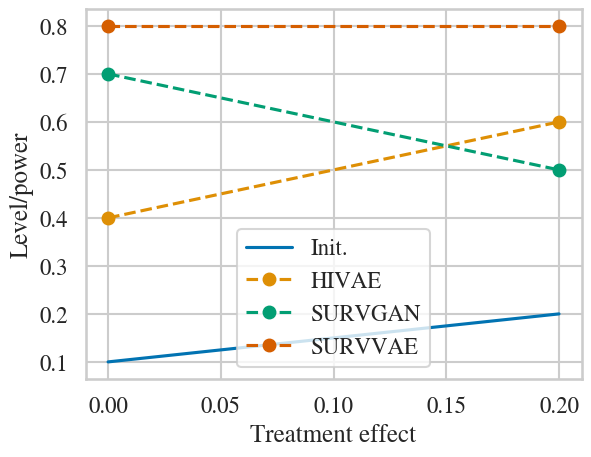

In [70]:
puiss_init = results.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
puiss_gen_hivae = results.groupby("H0_coef").mean()["reject_H0_gen_hivae"].to_numpy()
puiss_gen_survgan = results.groupby("H0_coef").mean()["reject_H0_gen_survgan"].to_numpy()
puiss_gen_survvae = results.groupby("H0_coef").mean()["reject_H0_gen_survvae"].to_numpy()
plt.plot(treat_effects,puiss_init, '-',label = "Init.")#, markersize=1)
plt.plot(treat_effects,puiss_gen_hivae, '--', marker='o',label = "HIVAE")
plt.plot(treat_effects,puiss_gen_survgan, '--', marker='o',label = "SURVGAN")
plt.plot(treat_effects,puiss_gen_survvae, '--', marker='o',label = "SURVVAE")
plt.xlabel("Treatment effect")
plt.ylabel("Level/power")
plt.legend()
plt.savefig("./dataset/" + dataset_name + "/results_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".jpeg")